## Implementation of the paper 'Image noise types recognition using convolutional neural network with principal components analysis'

#### doi: 10.1049/iet-ipr.2017.0374
##### Hui Ying Khaw1
##### Foo Chong Soon1
##### Joon Huang Chuah1
##### Chee-Onn Chow1'

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

plt.style.use("dark_background")


In [76]:
# Setting up the CNN model based on architecture proposed by paper.

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Input layer with shape (64, 64, 1) (But modified to 256, 256, 1)
model.add(layers.Input(shape=(256, 256, 1)))

# Convolutional layers
model.add(layers.Conv2D(5, (3, 3), activation='relu', padding='same'))

# Max-pooling layers
model.add(layers.MaxPooling2D(5, (2, 2)))

# Convolutional layers
model.add(layers.Conv2D(10, (8, 8), activation='relu', padding='same'))

# Max-pooling layer
model.add(layers.MaxPooling2D(10, (2, 2)))

# Flatten the output for the fully connected layer
model.add(layers.Flatten())

# Fully connected layer with 6 units
model.add(layers.Dense(6, activation='relu'))

# Softmax classifier
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 5)       50        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 126, 126, 5)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 126, 10)      3210      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 59, 59, 10)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 34810)             0         
                                                                 
 dense_6 (Dense)             (None, 6)                

In [77]:
# Types of noise the model will support:
NOISE_TYPE_IMPULSE = 0
NOISE_TYPE_GAUSSIAN = 1
NOISE_TYPE_SPECKLE = 2
NOISE_TYPE_POISSON = 3

# Ranges for noise types
IMPULSE_LOW_PROBABILITY = 0.025
IMPULSE_HIGH_PROBABILITY = 0.05
GAUSSIAN_LOW_SIGMA = 0.4
GAUSSIAN_HIGH_SIGMA = 0.6
SPECKLE_LOW_PROBABILITY = 0.04
SPECKLE_HIGH_PROBABILITY = 0.15
POISSON_LOW_SCALE_FACTOR = 2e+1
POISSON_HIGH_SCALE_FACTOR = 70

In [78]:
0# Add noise to the images (Train images is from LGG dataset)

lgg_dataset_dir = '../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m'

lgg_training_files = []

for root, folder_name, file_names in os.walk(lgg_dataset_dir):
    for file_name in file_names:
        file_path = os.path.join(root, file_name)
        lgg_training_files.append(file_path)
        
print(lgg_training_files[0])

../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m\data.csv


In [79]:
print('num of images: ', len(lgg_training_files))

num of images:  7860


In [80]:

# Load 500 images from dataset.

imgs = []

for i in range(2, 500):
    img = cv2.imread(lgg_training_files[i], cv2.IMREAD_GRAYSCALE)
    img = img.reshape((256, 256, 1))

    imgs.append(img)

image shape:  (256, 256, 1)


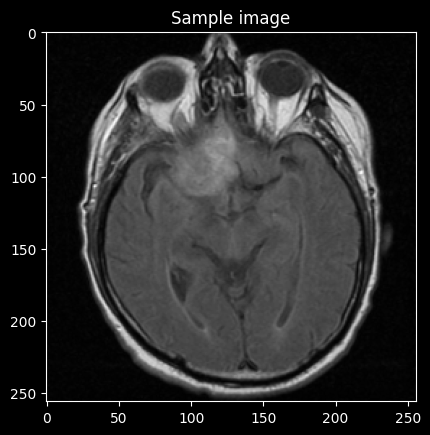

In [81]:

plt.title('Sample image')
plt.imshow(imgs[3], cmap='gray')
print('image shape: ', imgs[3].shape)

In [82]:
# Functions to add noise to image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    salt_coords = [np.random.randint(0, high=image.shape[0], size=num_salt),
                   np.random.randint(0, high=image.shape[1], size=num_salt)]
    noisy_image[salt_coords[0], salt_coords[1], :] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    pepper_coords = [np.random.randint(0, high=image.shape[0], size=num_pepper),
                     np.random.randint(0, high=image.shape[1], size=num_pepper)]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy_image

def add_gaussian_noise(image, mean=0, stddev=2):
    noisy_image = image.copy()

    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image[:, :], noise)
    
    return noisy_image

def add_speckle_noise(image, stddev=0.1):
    noisy_image = image.copy()
    
    noise = np.random.normal(0, stddev, image.shape)
    noisy_image[:, :] = np.uint8(np.clip(image[:, :] + image[:, :] * noise, 0, 255))
    
    return noisy_image

def add_poisson_noise(image, scale):
    noisy_image = image.copy()

    noise = np.random.poisson(scale, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return noisy_image

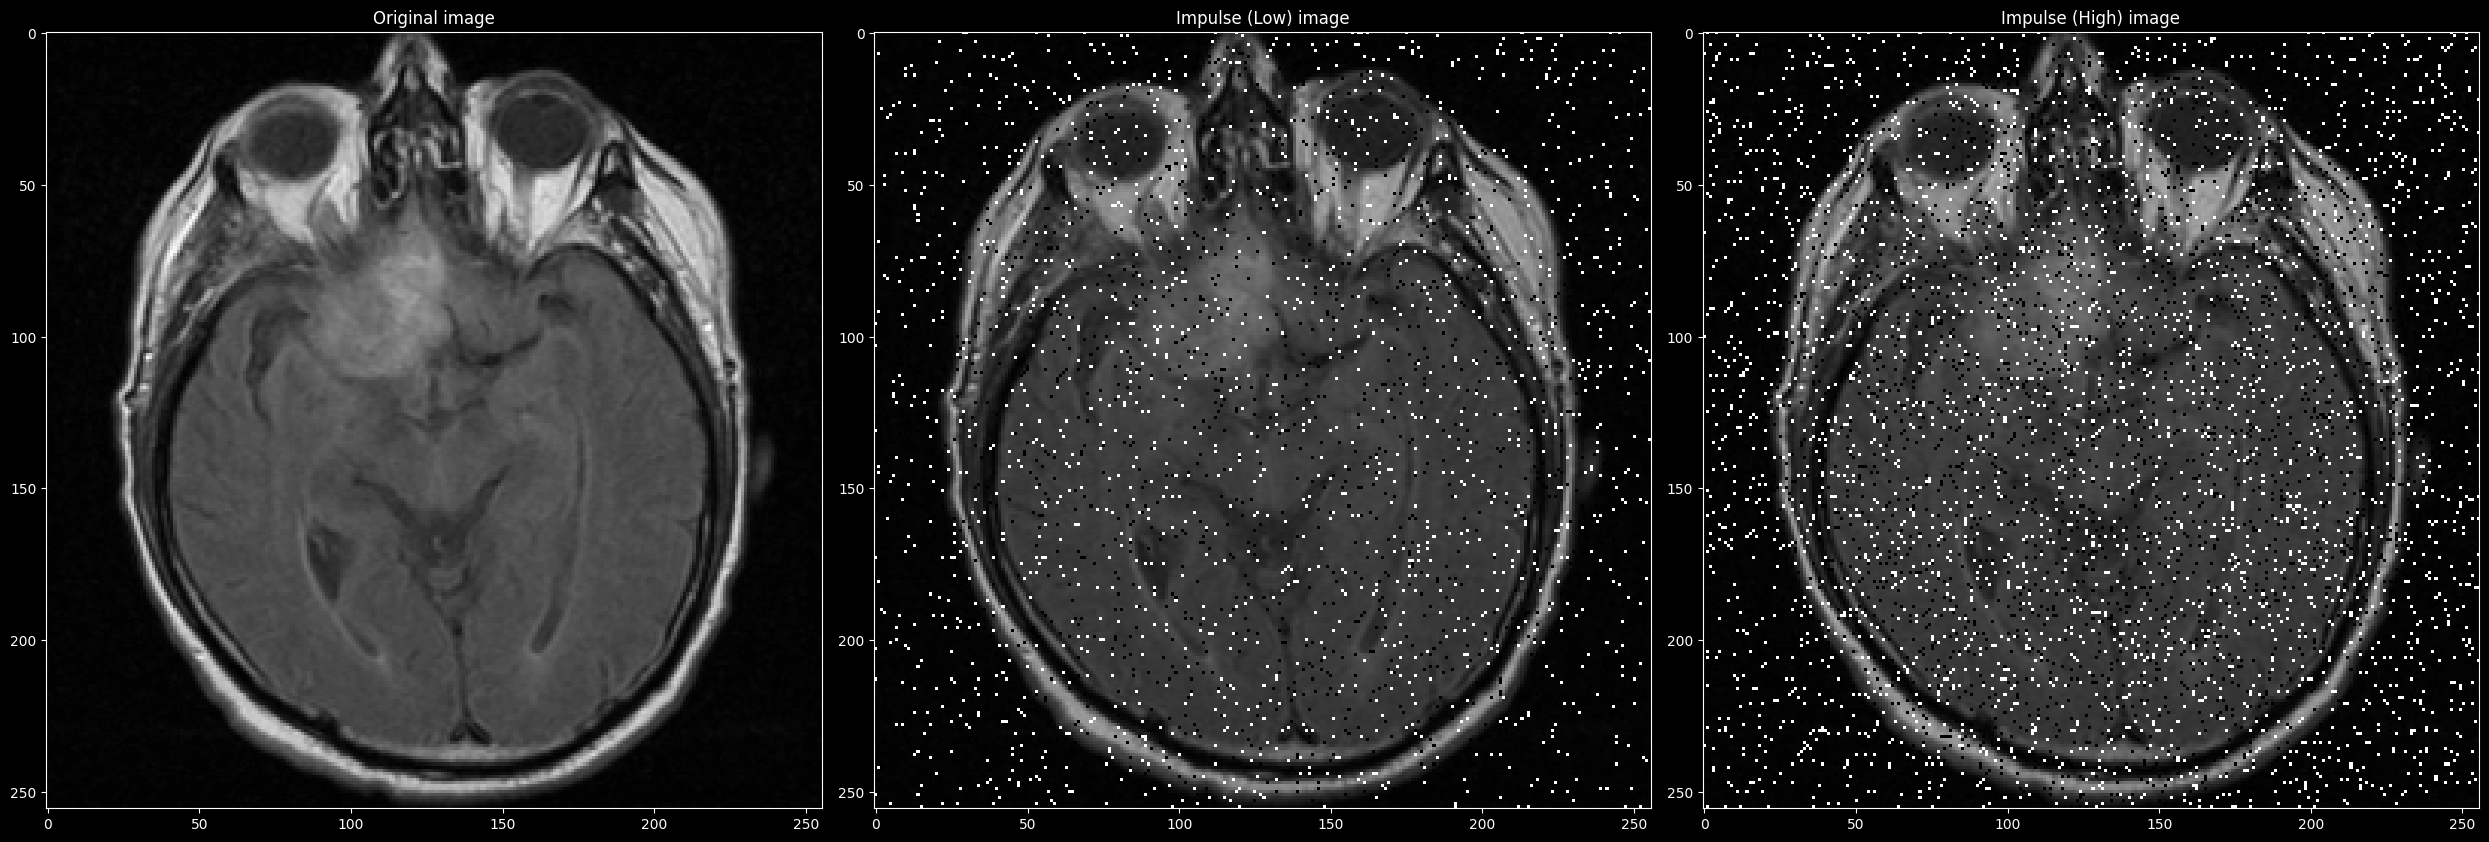

In [83]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]
fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Impulse (Low) image')
axes[1].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Impulse (High) image')
axes[2].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

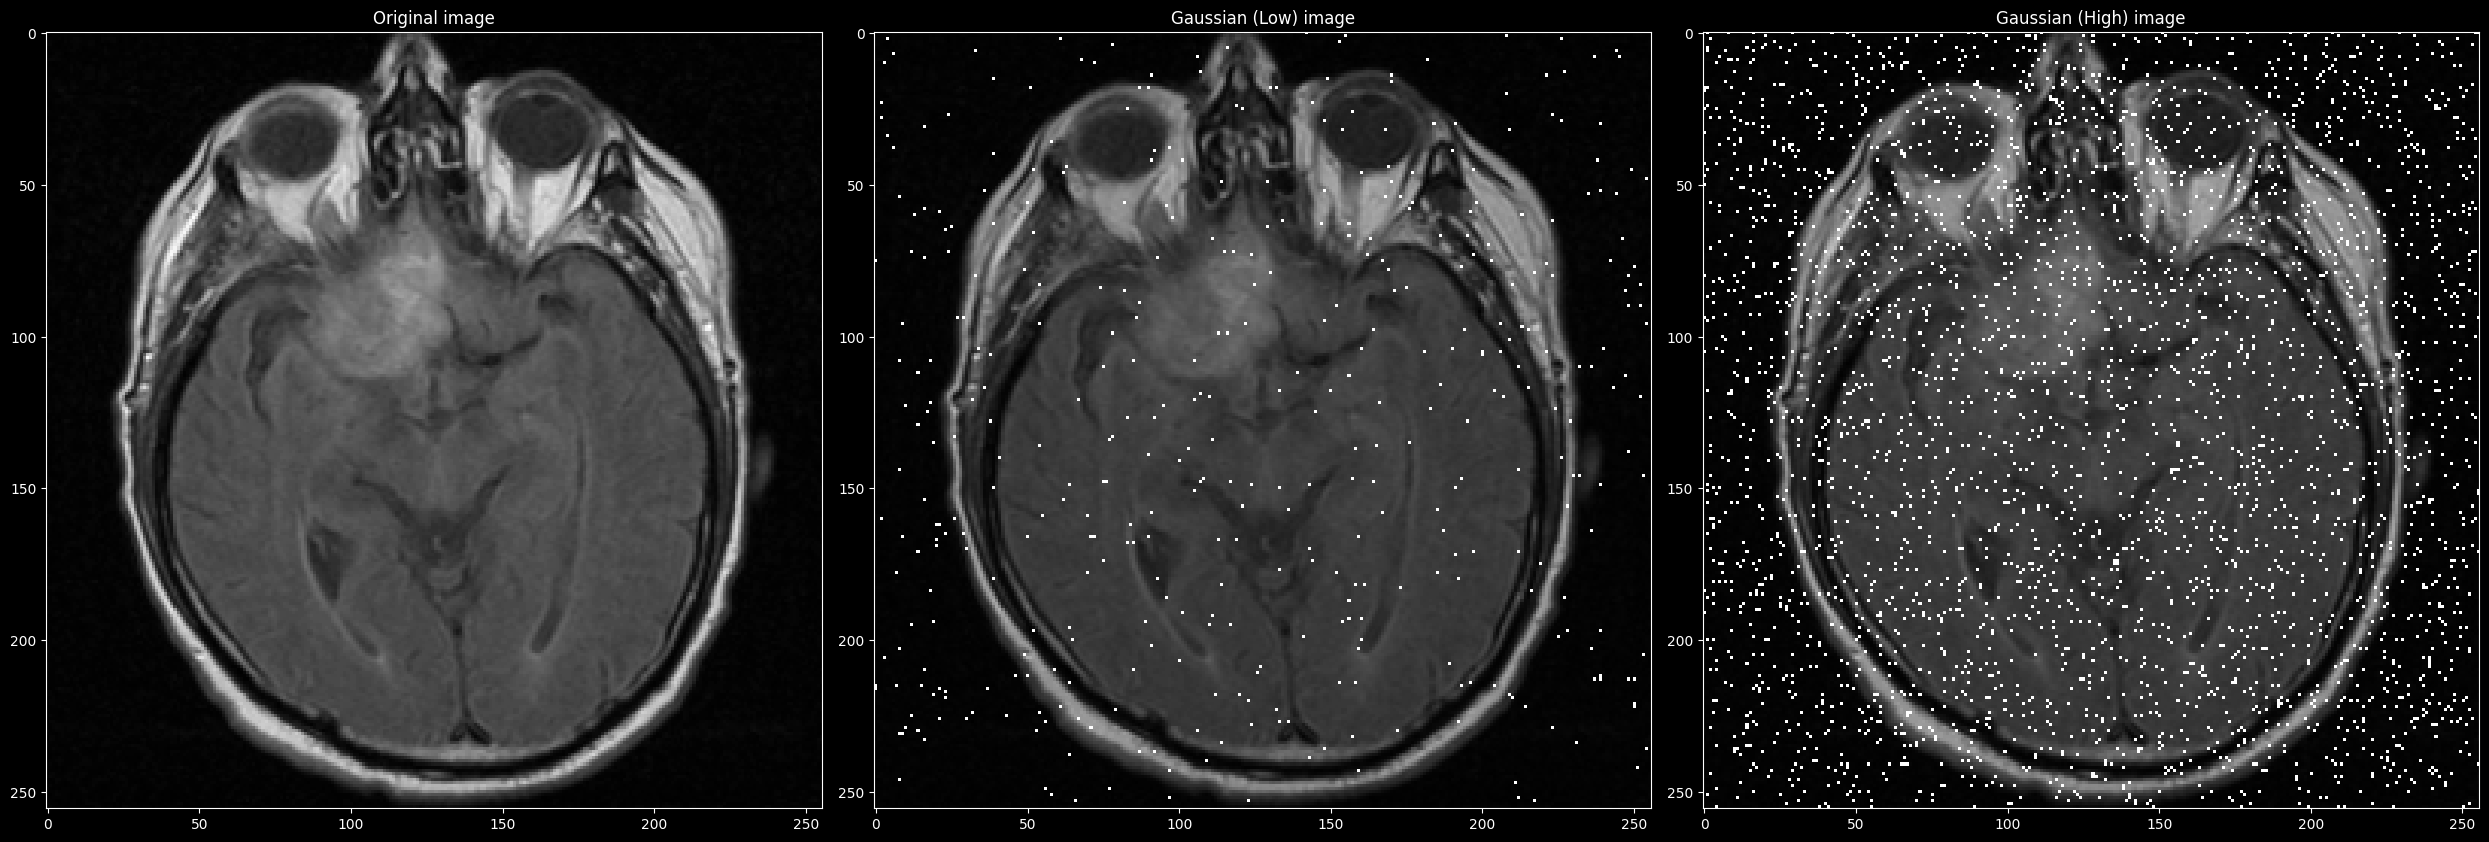

In [84]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Gaussian (Low) image')
axes[1].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_LOW_SIGMA), cmap='gray')  

axes[2].set_title('Gaussian (High) image')
axes[2].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_HIGH_SIGMA), cmap='gray')  

plt.tight_layout()  
plt.show()

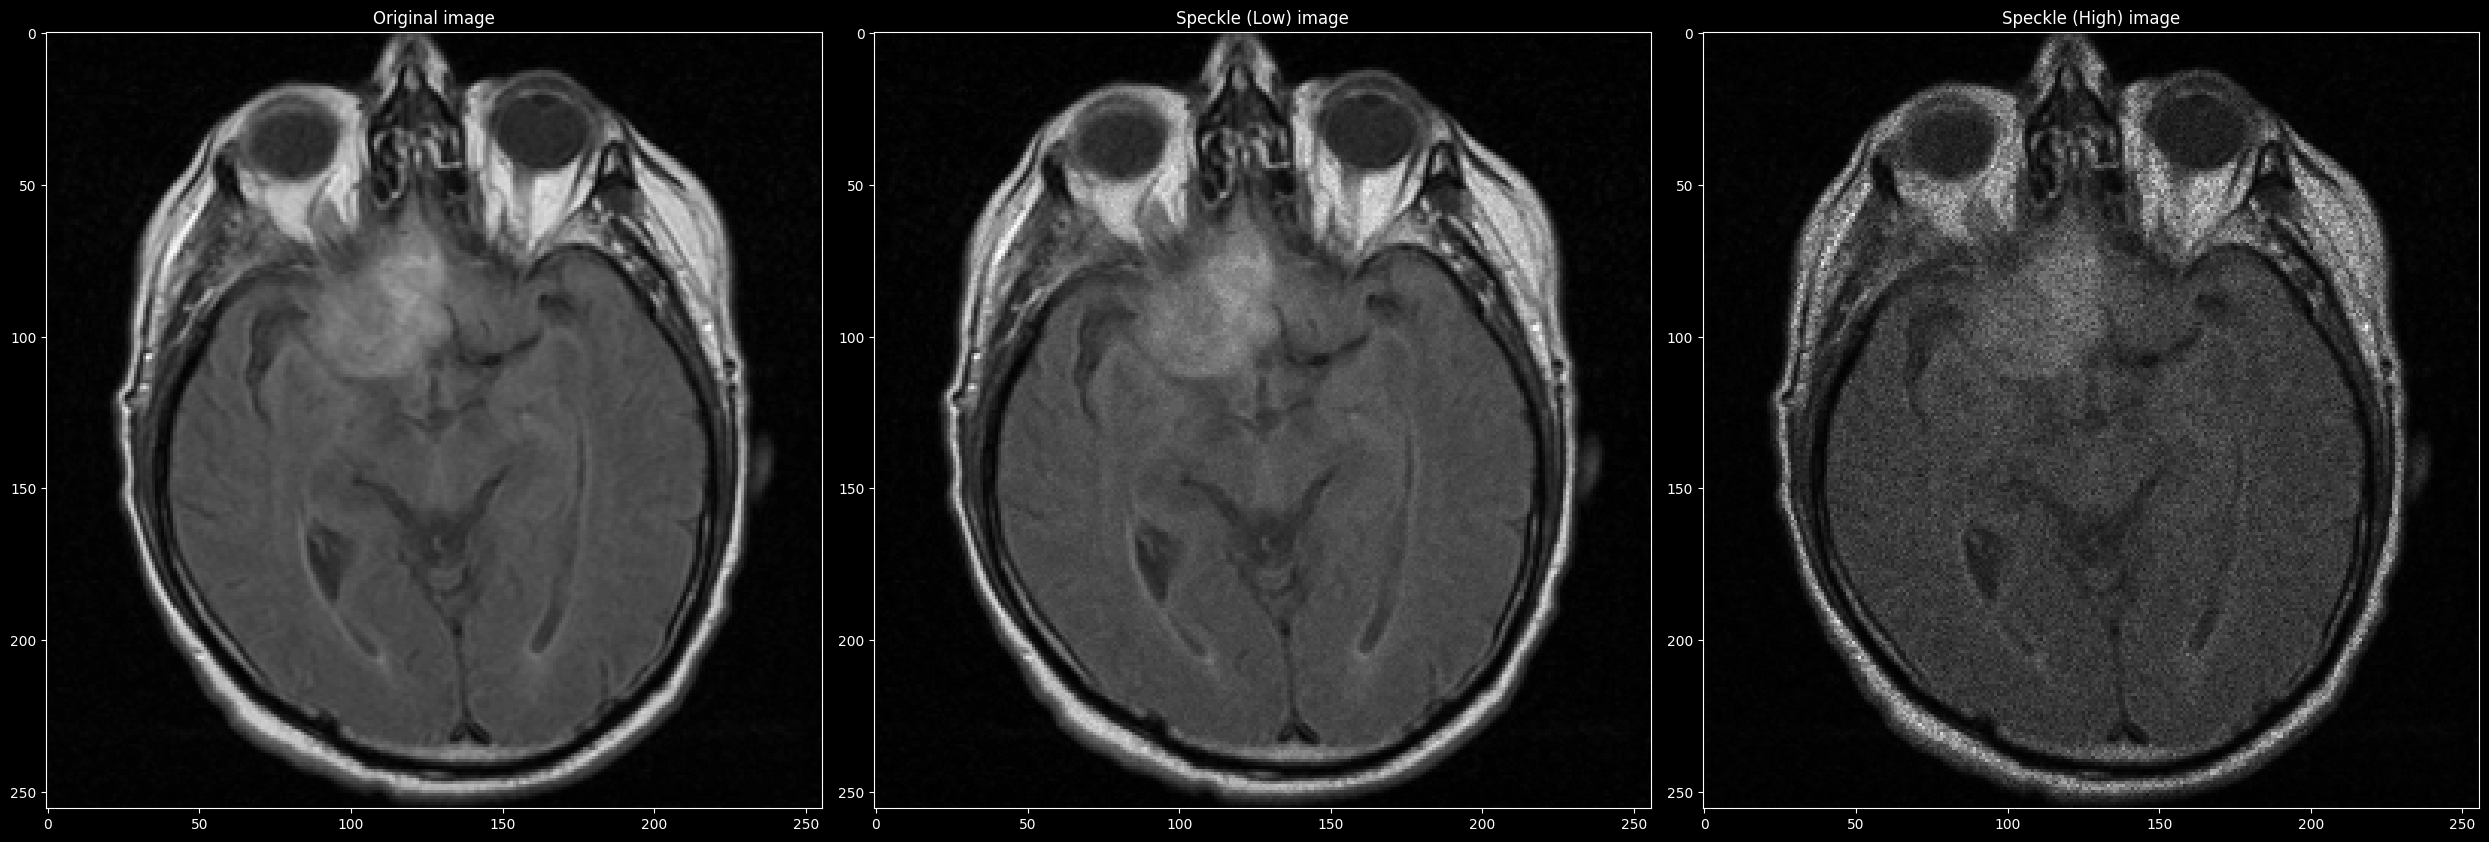

In [85]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Speckle (Low) image')
axes[1].imshow(add_speckle_noise(test_img, SPECKLE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Speckle (High) image')
axes[2].imshow(add_speckle_noise(test_img, SPECKLE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

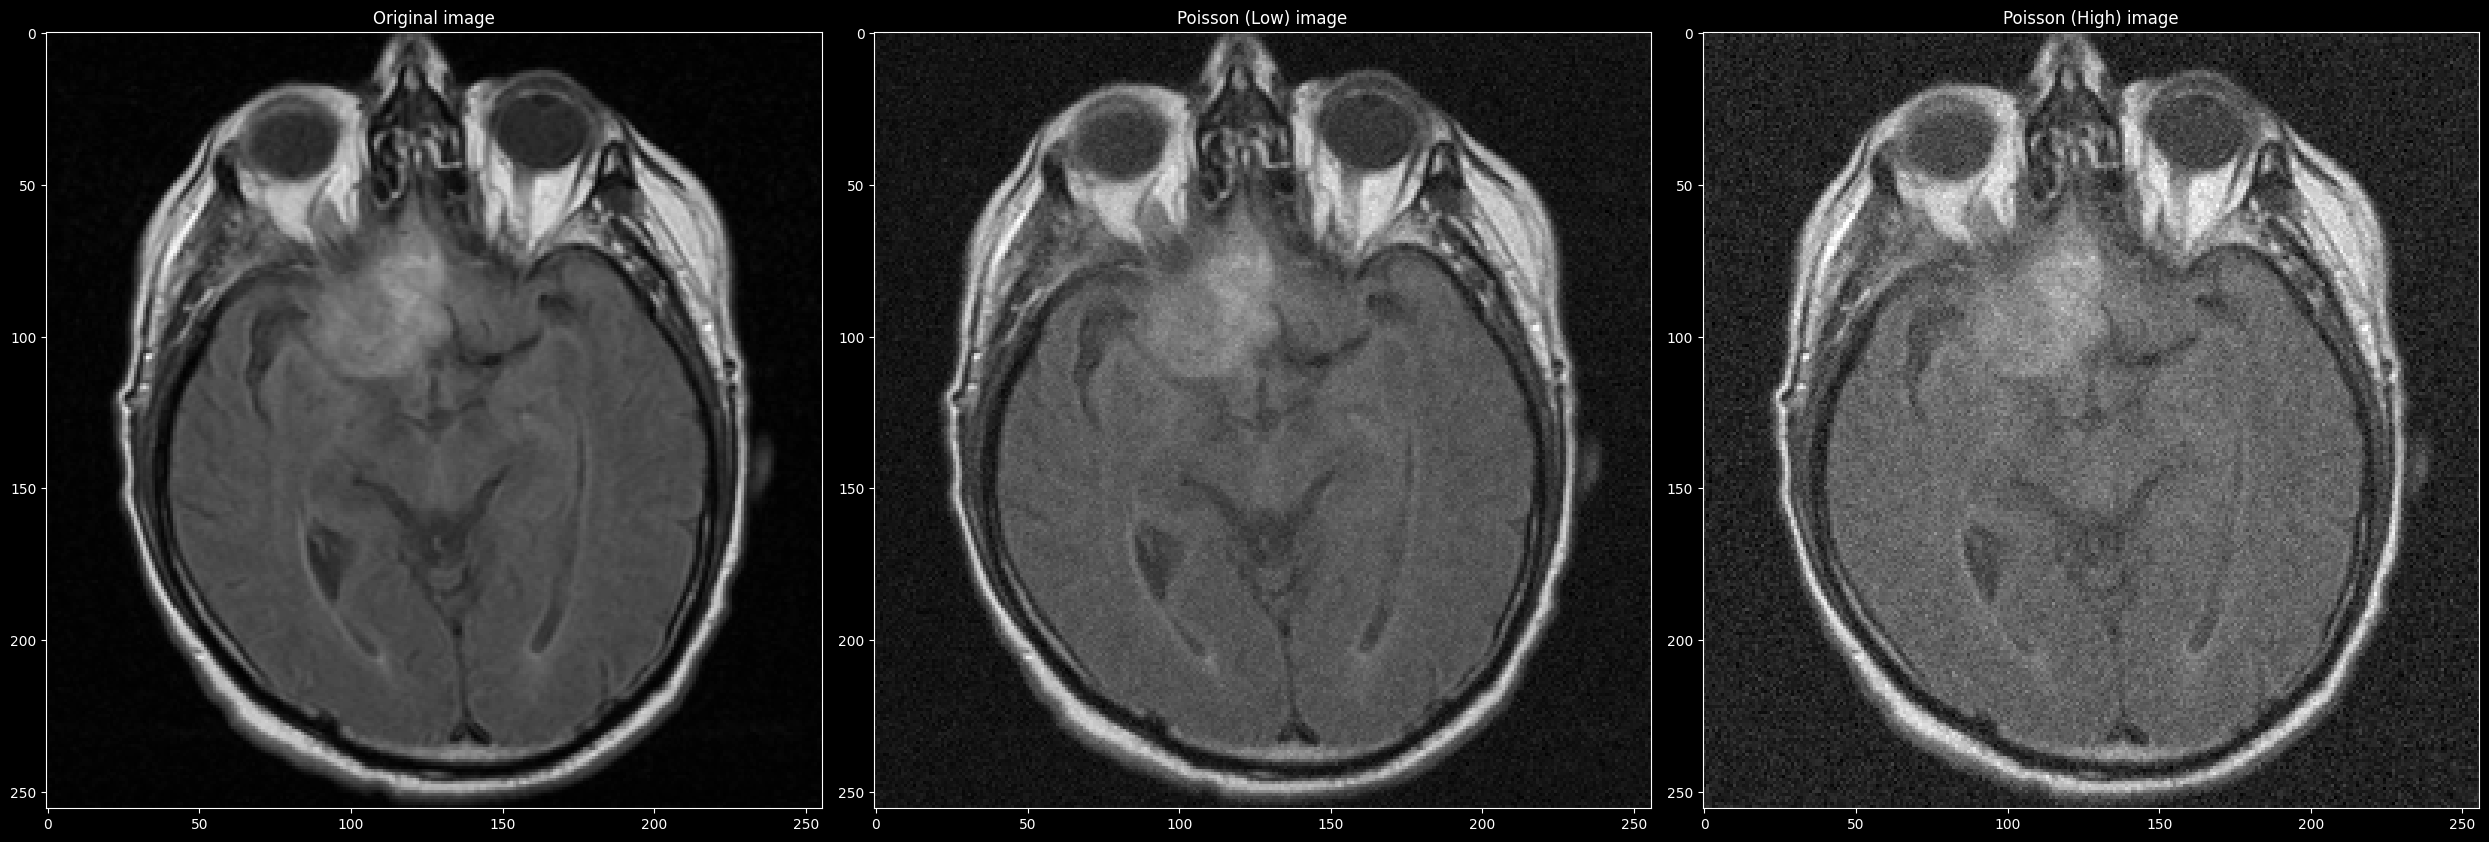

In [86]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Poisson (Low) image')
axes[1].imshow(add_poisson_noise(test_img, 2e+1), cmap='gray')  

axes[2].set_title('Poisson (High) image')
axes[2].imshow(add_poisson_noise(test_img, 70), cmap='gray')  

plt.tight_layout()  
plt.show()

In [87]:

# Setup training data
x_data = []
y_data = []

for img in imgs:
    x_data.append(add_salt_and_pepper_noise(img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY))
    y_data.append(NOISE_TYPE_IMPULSE)

    x_data.append(add_salt_and_pepper_noise(img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY))
    y_data.append(NOISE_TYPE_IMPULSE)
    
    x_data.append(add_gaussian_noise(img, 0, GAUSSIAN_LOW_SIGMA))
    y_data.append(NOISE_TYPE_GAUSSIAN)
    
    x_data.append(add_gaussian_noise(img, 0, GAUSSIAN_HIGH_SIGMA))
    y_data.append(NOISE_TYPE_GAUSSIAN)
    
    x_data.append(add_speckle_noise(img, SPECKLE_LOW_PROBABILITY))
    y_data.append(NOISE_TYPE_SPECKLE)
    
    x_data.append(add_speckle_noise(img, SPECKLE_HIGH_PROBABILITY))
    y_data.append(NOISE_TYPE_SPECKLE)
    
    x_data.append(add_poisson_noise(img, 2e+1))
    y_data.append(NOISE_TYPE_POISSON)
    
    x_data.append(add_poisson_noise(img, 70))
    y_data.append(NOISE_TYPE_POISSON)


In [92]:
print('x_data len: ', len(x_data))
print('x shape: ', x_data[0].shape)
print('y_data len: ', len(y_data))

x_data len:  3984
x shape:  (256, 256, 1)
y_data len:  3984


In [96]:
# Splitting data into train, test and validation

from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=104, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=104, test_size=0.25)

(256, 256, 1)


In [94]:
print('x train len ', len(x_train))
print('x test len ', len(x_test))
print('x val len ', len(x_val))
print('x train image shape', x_train[1].shape)
print('y train len ', len(y_train))

x train len  2241
x test len  996
x val len  747
x train image shape (256, 256)
y train len  2241


In [ ]:
# Convert y data to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

print(y_train[0])

[0. 0. 0. 1.]


In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256
  y sizes: 2241
Make sure all arrays contain the same number of samples.